In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras import Input
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import models, layers
import sys,os,math,pathlib
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

In [2]:
batch_size = 32
split_percent=0.3
rand_seed=123
shuffle_num=1000
EPOCHS=200
dir_path = 'D:/graduation_project/voice_data_files/2021_9/same_amount_voice/original_bad_o(per_500+aug(1050))'

In [3]:
data_dir = pathlib.Path(dir_path)
image_list = list(data_dir.glob('*/*.png'))
image_size = Image.open(image_list[0]).size
img_width=image_size[0]
img_height=image_size[1]

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent,
    subset="training",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10850 files belonging to 7 classes.
Using 7595 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent ,
    subset="validation",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10850 files belonging to 7 classes.
Using 3255 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(shuffle_num).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
print(class_names)

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [ ]:
K = num_classes
input_tensor = Input(shape=(img_height, img_width, 3), dtype='float32', name='input')
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x) 
    return x    
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)      
    shortcut = x
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
            shortcut = x            
    return x
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x

def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x

def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

resnet50.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

In [11]:
from keras.models import load_model
model_date="09_08"
model_name="aug(bad)+origin(bad)(batch=32)"
#h5 타입
resnet50.save('C:/Users/jaehee/Desktop/jupyter_proj/model/'+model_date+'/'+model_name+'.h5')
#tf 타입
resnet50.save('C:/Users/jaehee/Desktop/jupyter_proj/model/'+model_date+'/'+model_name, save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/jaehee/Desktop/jupyter_proj/model/09_08/aug(bad)+origin(bad)(batch=32)\assets


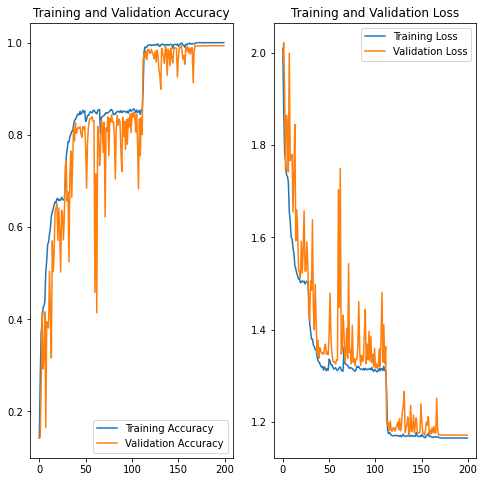

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('C:/Users/jaehee/Desktop/jupyter_proj/model/'+model_date+'/graph/'+model_name+".png",bbox_inches='tight',
                pad_inches=0)

In [23]:
from keras.preprocessing import image
file_name_list=['good_morning_bad.png','youtube_bad.png','sangho_bad.png','music_bad.png','traffic_bad.png','today_weather_bad.png','tomorrow_weather_bad.png']

for t in range(len(file_name_list)):
    image_path = 'C:/Users/jaehee/Desktop/graduation_project/voice_data_files/2021_9/same_amount_voice/orignal_bad_o(test_voice)/'+file_name_list[t]
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    #print(img_array)
    predictions = resnet50.predict(img_array)
    #print(predictions)
    score = tf.nn.softmax(predictions[0])
    #print(score)
    print("{}데이터는 {} 클래스일 확률이 {:.2f}%입니다..".format(file_name_list[t],class_names[np.argmax(score)], 100 * np.max(score)))

good_morning_bad.png데이터는 good_morning_u 클래스일 확률이 31.18%입니다..
youtube_bad.png데이터는 youtube_dongbinna_u 클래스일 확률이 31.18%입니다..
sangho_bad.png데이터는 call_sangho_u 클래스일 확률이 31.18%입니다..
music_bad.png데이터는 recommend_music_u 클래스일 확률이 31.18%입니다..
traffic_bad.png데이터는 how_working_path_u 클래스일 확률이 31.18%입니다..
today_weather_bad.png데이터는 today_weather_u 클래스일 확률이 31.18%입니다..
tomorrow_weather_bad.png데이터는 tomorrow_weather_u 클래스일 확률이 31.18%입니다..


## 모델 불러오기

In [73]:
model_name="aug(bad)+origin(bad)(batch=32).h5"
model_dir='C:/Users/jaehee/Desktop/jupyter_proj/model'
model_date='09_08'
new_data_dir='C:/Users/jaehee/Desktop/graduation_project/voice_data_files/2021_9/same_amount_voice/augment_bad_o(test_voice)/test_class'
batch_size = 8
split_percent=0.3
rand_seed=123
shuffle_num=1000
EPOCHS=20

In [66]:
data_dir = pathlib.Path(new_data_dir)
image_list = list(data_dir.glob('*/*.png'))
image_size = Image.open(image_list[0]).size
img_width=image_size[0]
img_height=image_size[1]

In [67]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent,
    subset="training",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 30 files belonging to 7 classes.
Using 21 files for training.


In [68]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent ,
    subset="validation",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 30 files belonging to 7 classes.
Using 9 files for validation.


In [69]:
class_names = train_ds.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(shuffle_num).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [58]:
test_h5 = load_model(model_dir+'/'+model_date+'/'+model_name)
test_h5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 130, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 130, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [59]:
for layer in test_h5.layers[:-1]:
    layer.trainable = False

In [60]:
test_h5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 130, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 130, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [61]:
output_layer = test_h5.layers[-1]
output_layer.output.shape

TensorShape([None, 7])

In [27]:
print(test_h5.input)

Tensor("input_4:0", shape=(None, 200, 260, 3), dtype=float32)


In [29]:
print(test_h5.layers[-2].output)
print(test_h5.layers[-1].output)
#print(test_h5.layers[-2].output)

Tensor("global_average_pooling2d/Mean_4:0", shape=(None, 2048), dtype=float32)
Tensor("dense/Softmax_4:0", shape=(None, 7), dtype=float32)


In [62]:
# 가중치를 이어받은 새로운 모델 생성 # 기존 모델의 다른 레이어층 가중치 봉인
resume_model = Model(test_h5.input, output_layer(test_h5.layers[-2].output))
resume_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 130, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 130, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [71]:
# 컴파일
resume_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
resume_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200, 260, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 266, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 130, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 130, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

In [75]:
EPOCHS=20
history = resume_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/20


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_5/conv2d/Conv2D (defined at <ipython-input-72-29949ddd50bc>:5) ]] [Op:__inference_train_function_99244]

Function call stack:
train_function


In [76]:
tf.__version__

'2.3.0'